In [128]:
from PIL import Image
import numpy as np
import json
with open("/raid/data_modal/IAPR_TC-12/img_tagslabel.json","r") as f:
    taglabel = json.load(f)
with open('/raid/data_modal/IAPR_TC-12/filterd_label_name.json', 'r') as f:
    filterd_label_name  = json.load(f)
with open('/raid/data_modal/IAPR_TC-12/class_name.json', 'r') as f:
    class_name  = json.load(f)
def display_aipr(image_id):
    dir_path = "/raid/data_modal/IAPR_TC-12/hashing_images/"
    this_name = np.array(class_name)[np.array(taglabel[str(image_id)]["label"])>0]
    print(this_name)
    print(taglabel[str(image_id)]["tags"])
    display(Image.open(dir_path+"{}.jpg".format(image_id)))
def get_tag(image_id):
    return taglabel[image_id]["tags"]
def get_label(image_id):
    return np.array(class_name)[np.array(taglabel[str(image_id)]["label"])>0]
# from PIL import Image
# import numpy as np
# import json
# with open("/raid/data_modal/MIR_Flickr_25k/new_img_tagslabel.json","r") as f:
#     taglabel = json.load(f)
# with open('/raid/data_modal/MIR_Flickr_25k/class_name.json', 'r') as f:
#     class_name  = json.load(f)
# def display_aipr(image_id):
#     dir_path = "/raid/data_modal/MIR_Flickr_25k/mirflickr/"
#     this_name = np.array(class_name)[np.array(taglabel[str(image_id)]["label"])>0]
#     print(this_name)
#     print(taglabel[str(image_id)]["tags"])
#     display(Image.open(dir_path+"{}.jpg".format(image_id)))
# def get_tag(image_id):
#     return taglabel[image_id]["tags"]
# def get_label(image_id):

#     return np.array(class_name)[np.array(taglabel[str(image_id)]["label"])>0]

In [129]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from logging import log
import re
import numpy as np
import os.path as op
from hashing_module.triplet_loss import *
from torch.autograd.grad_mode import F

from torch.nn.modules import loss
from torch.utils.data.sampler import Sampler

import argparse
from oscar.modeling.modeling_bert import HashingformerALL,normal_label
from pytorch_transformers import BertTokenizer, BertConfig
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import tqdm
from torch.autograd import Variable
from oscar.utils.tsv_file import TSVFile
from torch.nn import CrossEntropyLoss
import json
import base64
import random
from pytorch_transformers import AdamW, WarmupLinearSchedule, WarmupConstantSchedule
from hashing_module.utils import calc_map_k
from oscar.utils.logger import setup_logger
from oscar.utils.misc import mkdir

In [130]:
def f1_calc(logit,sim,threshold):
    logit = logit.detach().cpu()
    sim = sim.detach().cpu()

    t = (sim>threshold).sum()
    if(t<1):
        return 0
    tp = (logit[sim>threshold]>threshold).sum()
    p = (logit>threshold).sum()
    
    if(tp>0 and p>0 and t>0):
        recall = tp/t
        precision = tp/p
        f1 = 2* recall*precision/(recall+precision)
        return f1
    return 0

In [131]:
class RetrievalDataset(Dataset):
    """ Image/Text Retrieval Dataset"""
    def __init__(self, args,tokenizer,split="train"):
        """
        tokenizer: tokenizer to process caption text.
        args: configureation parameters including max_seq_length, etc.
        split: used to infer the data used for training or testing. 
             All files are in .pt format of a dictionary with image keys and 
             image features (pytorch tensors), captions (list of str, support multiple
             captions per image), labels (list of dictionary or str of all labels),

        """
        super(RetrievalDataset, self).__init__()
        with open(args.tagslabel ,"r") as f:
            self.tagslabel = json.load(f)   
        self.args = args  
        self.split = split      
        self.img_file = args.img_feat_file
        self.img_tsv = TSVFile(self.img_file)
        self.img_keys = list(self.tagslabel.keys())  # img_id as int
        imgid2idx_file = op.join(op.dirname(self.img_file), 'imageid2idx.json')
        self.image_id2idx = json.load(open(imgid2idx_file))  # img_id as string
        with open(args.class_name,"r") as f:
            self.class_name = json.load(f)
            self.class_name = np.array(self.class_name)
        if(args.split_keys):
            with open(args.split_keys,"r") as f:
                self.img_keys = json.load(f)
                self.img_keys = [str(i) for i in self.img_keys]
        else:
            random.seed(279834)
            random.shuffle(self.img_keys)
        if(split=="train"):
            self.img_keys = self.img_keys[args.query_size:args.training_size + args.query_size]
            total_label = []
            for i in self.img_keys:
                total_label.append(self.tagslabel[i]["label"])
            self.total_label = torch.Tensor(total_label)
        elif(split=="query"):
            self.img_keys = self.img_keys[:args.query_size]
        else:
            self.img_keys = self.img_keys[args.query_size:args.database_size+ args.query_size]
        label_data_dir = op.dirname(self.img_file)
        label_file = os.path.join(label_data_dir, "label.tsv")
        self.label_tsv = TSVFile(label_file)
        self.labels = {}

        
        for line_no in tqdm(range(self.label_tsv.num_rows())):
            row = self.label_tsv.seek(line_no)
            image_id = row[0]
            if image_id in self.img_keys:
                results = json.loads(row[1])
                objects = results['objects'] if type(
                    results) == dict else results
                self.labels[image_id] = {
                    "image_h": results["image_h"] if type(
                        results) == dict else 600,
                    "image_w": results["image_w"] if type(
                        results) == dict else 800,
                    "class": [cur_d['class'] for cur_d in objects],
                    "boxes": np.array([cur_d['rect'] for cur_d in objects],
                                        dtype=np.float32)
                }
        self.label_tsv._fp.close()
        self.label_tsv._fp = None   
        self.output_mode = 'classification'
        self.tokenizer = tokenizer
        self.max_seq_length = 35
        self.max_img_seq_len = 70
        self.args.max_label_length = args.max_label_length
    def get_od_labels(self, img_key):

        if type(self.labels[img_key]) == str:
            od_labels = self.labels[img_key]
        else:
            od_labels = ' '.join(self.labels[img_key]['class'])
        return od_labels
    def class_tokenize(self,labels,max_length=15):
        all_size = labels.shape[0]
        final_label = []
        for i in range(all_size):
            this_label = torch.zeros((max_length+2))
            class_name = self.class_name[labels[i]>0]
            
            tokens = self.tokenizer.tokenize("".join(class_name))
            tokens = [self.tokenizer.cls_token] + tokens[0:max_length] + [self.tokenizer.sep_token]
            input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
            
            this_label[0:len(input_ids)] = torch.Tensor(input_ids)
            final_label.append(this_label)
        final_label = torch.stack(final_label).long()  
        return final_label  

   
    def tensorize_example(self, text_a, img_feat, text_b=None, 
            cls_token_segment_id=0, pad_token_segment_id=0,
            sequence_a_segment_id=0, sequence_b_segment_id=1):
        tokens_a = self.tokenizer.tokenize(text_a)
        if len(tokens_a) > self.max_seq_length - 2:
            tokens_a = tokens_a[:(self.max_seq_length - 2)]

        tokens = [self.tokenizer.cls_token] + tokens_a + [self.tokenizer.sep_token]
        segment_ids = [cls_token_segment_id] + [sequence_a_segment_id] * (len(tokens_a) + 1)
    
        if text_b:
            tokens_b = self.tokenizer.tokenize(text_b)
            if len(tokens_b) > self.max_seq_length   - 2:#a
                tokens_b = tokens_b[: (self.max_seq_length  - 2)]
            tokens_b = [self.tokenizer.cls_token] +tokens_b+ [self.tokenizer.sep_token]
            segment_ids_b = [sequence_b_segment_id] + [sequence_b_segment_id] * (len(tokens_b) -1)
        #这儿分a padding
        seq_len_a = len(tokens)
        seq_padding_len_a = self.max_seq_length - seq_len_a
        tokens += [self.tokenizer.pad_token] * seq_padding_len_a
        segment_ids += [pad_token_segment_id] * seq_padding_len_a
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        #b padding
        seq_len_b = len(tokens_b)
        seq_padding_len_b = self.max_seq_length - seq_len_b
        tokens_b += [self.tokenizer.pad_token] * seq_padding_len_b
        segment_ids_b += [pad_token_segment_id] * seq_padding_len_b
        input_ids_b = self.tokenizer.convert_tokens_to_ids(tokens_b)
        #合并
        input_ids = input_ids+input_ids_b
        segment_ids = segment_ids+segment_ids_b
        # image features
        img_len = img_feat.shape[0]

        if img_len > self.max_img_seq_len:
            img_feat = img_feat[0 : self.max_img_seq_len, :]
            img_len = img_feat.shape[0]
            img_padding_len = 0
        else:
            img_padding_len = self.max_img_seq_len - img_len
            padding_matrix = torch.zeros((img_padding_len, img_feat.shape[1]))
            
            img_feat = torch.cat((img_feat, padding_matrix), 0)

        # generate attention_mask
        att_mask_type = "CLR"
        if att_mask_type == "CLR":
            attention_mask = [1] * seq_len_a + [0] * seq_padding_len_a +[1] * seq_len_b + [0] * seq_padding_len_b +  [1] * img_len + [0] * img_padding_len 


        input_ids = torch.tensor(input_ids, dtype=torch.long)
        attention_mask = torch.tensor(attention_mask, dtype=torch.long)
        segment_ids = torch.tensor(segment_ids, dtype=torch.long)
        return (input_ids, attention_mask, segment_ids, img_feat)

    def __getitem__(self, index):
        
        img_key = self.img_keys[index]
      
        feature = self.get_image(img_key)
        tag_list = self.tagslabel[img_key]["tags"]
        if(isinstance(tag_list,list)):
            caption = ""
            for i in tag_list:
                caption+=i+" "
            caption=caption.strip()
        else:#is a string
            caption  = tag_list
        od_labels = self.get_od_labels(img_key)
        example = self.tensorize_example(caption, feature, text_b=od_labels)
        label = self.tagslabel[img_key]["label"]
        label=torch.tensor(label, dtype=torch.long)
        if(self.split=="train"):
            raw_label = self.generate_samples(label,self.args.negative_number)
            #negative_label = normal_label(raw_label,max_length = self.args.max_label_length )
            negative_label = self.class_tokenize(raw_label,max_length = self.args.max_label_length )
            return tuple(list(example) + [label,negative_label,raw_label]),img_key
        else:
            return tuple(list(example) + [label]),img_key

    def generate_samples(self, label,negative_number = 99):
        mask = 1-label #
        negative_samples = []
        positive_sample = label 
        all_index =torch.arange(self.total_label.shape[0])
        while(len(negative_samples)<negative_number//2):
            smaples=  torch.from_numpy(np.random.choice(2, self.args.class_number,p=[1-5/self.args.class_number,5/self.args.class_number]))
            is_positive = (smaples*label).sum()>0
            if(not is_positive):
                negative_samples.append(smaples)
        
        while(len(negative_samples)<negative_number):
            sim = torch.matmul(label.unsqueeze(0).float(),self.total_label.float().t()).squeeze(0)>0
            negative = all_index[~sim]
            smaples_index=  np.random.choice(negative.numpy(), 1)[0]
            negative_samples.append(self.total_label[smaples_index])        
        final_sample = [positive_sample]+negative_samples
        final_sample = torch.stack(final_sample)
        return final_sample
    def get_image(self, image_id):
        image_idx = self.image_id2idx[str(image_id)]
        row = self.img_tsv.seek(image_idx)
        num_boxes = int(row[1])
        features = np.frombuffer(base64.b64decode(row[-1]),
                                 dtype=np.float32).reshape((num_boxes, -1)).copy()
        t_features = torch.from_numpy(features)
        return t_features

    def __len__(self):
        return len(self.img_keys) 

In [132]:
class Opt():
    def __init__(self) -> None:
        self.use_gpu = True
        self.training_size = 10000
        self.query_size = 2000
        self.bit = 64
        self.database_size = 18000 
        self.gamma = 1
        self.eta = 1
        self.valid = True
        self.batch_size = 64
        self.margin = 0.4
        self.gamma = 1
        self.beta = 1
        self.alpha = 1
opt = Opt()

In [133]:
parser = argparse.ArgumentParser()
parser.add_argument("--num_train_epochs", default=1000, type=int, 
                    help="Total number of training epochs to perform.")
parser.add_argument("--class_name", default='/raid/data_modal/MIR_Flickr_25k/class_name.json"', type=str, required=False,
                    help="The input data dir with all required files.")
parser.add_argument("--split_keys", default='', type=str, required=False,
                    help="split_keys")
parser.add_argument("--tagslabel", default='MIR_Flickr_25k/img_tagslabel.json', type=str, required=False,
                    help="The input data dir with all required files.")
parser.add_argument("--img_feat_file", default='/MIR_Flickr_25k/vinvl_data/vinvl_vg_x152c4/predictions.tsv', type=str, required=False,
                    help="The absolute address of the image feature file.")
parser.add_argument("--output_dir", default='output/log_aipr', type=str, required=False,
                    help="The output directory to save checkpoint and test results.")
parser.add_argument("--num_workers", default=4, type=int, help="Workers in dataloader.")
parser.add_argument("--eval_model_dir", type=str, default='', 
                    help="Model directory for evaluation.")   
parser.add_argument("--do_lower_case", action='store_true', 
                    help="Set this flag if you are using an uncased model.")   
parser.add_argument("--output_file", type=str, default='', 
                    help="Model directory for evaluation.")  
parser.add_argument("--learning_rate", default=2e-5, type=float, help="The initial lr.")
parser.add_argument("--weight_decay", default=0.05, type=float, help="Weight deay.")
parser.add_argument("--adam_epsilon", default=1e-8, type=float, help="Epsilon for Adam.")
parser.add_argument("--max_grad_norm", default=1.0, type=float, help="Max gradient norm.")
parser.add_argument("--warmup_steps", default=0, type=int, help="Linear warmup.")
parser.add_argument("--scheduler", default='linear', type=str, help="constant or linear.")
parser.add_argument("--bit", default=64, type=int, help="constant or linear.")
parser.add_argument("--class_number", default=255, type=int, help="constant or linear.")  
parser.add_argument("--training_size", default=10000, type=int, help="constant or linear.") 
parser.add_argument("--query_size", default=2000, type=int, help="constant or linear.") 
parser.add_argument("--database_size", default=18000, type=int, help="constant or linear.")
parser.add_argument("--no_pretrain", action='store_true', help="constant or linear.")
parser.add_argument("--negative_number", default=9, type=int, help="constant or linear.")
parser.add_argument("--max_label_length", default=10, type=int, help="constant or linear.")
lists = [
                "--tagslabel",
                "/raid/data_modal/IAPR_TC-12/img_tagslabel.json",
                "--img_feat_file",
                "/raid/data_modal/IAPR_TC-12/vinvl/use_for_vinvl/feature.tsv",
                "--do_lower_case",
                "--eval_model_dir",
                "/raid/whf/ObjectContrastiveTransformer/output/IAPR_label_analysis/checkpoint-348",
                "--training_size","10000",
                "--query_size","2000",
                "--database_size","18000",
                "--class_number","255",
                "--class_name","/raid/data_modal/IAPR_TC-12/class_name.json",
            ]

# lists =  [
#                 "--tagslabel",
#                 "/raid/data_modal/MIR_Flickr_25k/new_img_tagslabel.json",
#                 "--img_feat_file",
#                 "/raid/data_modal/MIR_Flickr_25k/vinvl_data/use_for_vinvl/feature.tsv",
#                 "--do_lower_case",
#                 "--output_dir",
#                 "output/unit_pretrain_flicker",
#                 "--eval_model_dir",
#                 "/raid/whf/ObjectContrastiveTransformer/output/case_study_flicker/checkpoint-22",
#                 "--training_size","10000",
#                 "--query_size","2000",
#                 "--database_size","18015",
#                 "--class_number","24",
#                 "--class_name","/raid/data_modal/MIR_Flickr_25k/class_name.json",
               
#             ]
args = parser.parse_args(lists)

In [134]:
opt.class_number = args.class_number
device = torch.device("cuda")
config_class, tokenizer_class = BertConfig, BertTokenizer
checkpoint = args.eval_model_dir
tokenizer = tokenizer_class.from_pretrained(checkpoint, do_lower_case=args.do_lower_case)
config = config_class.from_pretrained(checkpoint)
config.class_number = opt.class_number
config.bit = args.bit
model = HashingformerALL(None,config)
if(not args.no_pretrain):
    if(not os.path.exists(checkpoint+"/pytorch_model.bin")):
        sd = torch.load(checkpoint+"/model.cpkt", map_location="cpu")
    else:
        sd = torch.load(checkpoint+"/pytorch_model.bin", map_location="cpu")
    missing, unexpected = model.load_state_dict(sd, strict=False)  
model.to(device)

HashingformerALL(
  (bert): BertImgModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CaptionBertEncoder(
      (layer): ModuleList(
        (0): CaptionBertLayer(
          (attention): CaptionBertAttention(
            (self): CaptionBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Fu

In [136]:
model_base = HashingformerALL(None,config)

sd = torch.load("/raid/whf/ObjectContrastiveTransformer/output/case_study_IAPR_base/checkpoint-65/model.cpkt", map_location="cpu")
#sd = torch.load("/raid/whf/ObjectContrastiveTransformer/output/case_study_flicker_base/checkpoint-20/model.cpkt", map_location="cpu")
missing, unexpected = model_base.load_state_dict(sd, strict=False)  
model_base.to(device)

HashingformerALL(
  (bert): BertImgModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): FusedLayerNorm(torch.Size([768]), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CaptionBertEncoder(
      (layer): ModuleList(
        (0): CaptionBertLayer(
          (attention): CaptionBertAttention(
            (self): CaptionBertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Fu

In [137]:

query_dataset = RetrievalDataset(args,tokenizer,"query")
retrieval_dataset = RetrievalDataset(args,tokenizer,"retrieval")


100%|██████████| 17585/17585 [00:07<00:00, 2237.59it/s]


In [138]:
def generate_code(model, query_dataloader):
    labels = []
    i_hashing = []
    t_hashing = []
    keys = []
    for batch,key in tqdm(query_dataloader):
        train_input_ids_this = batch[0].long().cuda()
        train_attention_mask_this = batch[1].long().cuda()
        train_token_type_ids_this = batch[2].long().cuda()
        train_img_feats_this = batch[3].cuda()
        label = batch[4].cuda()
        with torch.no_grad():
            cur_f= model(input_ids=train_input_ids_this,token_type_ids=train_token_type_ids_this,
                                    attention_mask=train_attention_mask_this,img_feats=train_img_feats_this,modal="t")


            cur_g= model(input_ids=train_input_ids_this,token_type_ids=train_token_type_ids_this,
                                    attention_mask=train_attention_mask_this,img_feats=train_img_feats_this,modal="i")
            
        i_hashing.append(cur_g)
        t_hashing.append(cur_f)
        keys.extend(key)
        labels.append(label)
    labels = torch.cat(labels,0)
    i_hashing = torch.cat(i_hashing,0)
    t_hashing = torch.cat(t_hashing,0)

    
    return keys,labels,i_hashing,t_hashing

In [139]:
model.eval()
query_sampler = SequentialSampler(query_dataset)
query_dataloader = DataLoader(query_dataset, sampler=query_sampler,
        batch_size=512, num_workers=4)
retrieval_sampler = SequentialSampler(retrieval_dataset)
retrieval_dataloader = DataLoader(retrieval_dataset, sampler=retrieval_sampler,
        batch_size=512, num_workers=4)
keys,labels,i_hashing,t_hashing = generate_code(model,query_dataloader)

keys_base,labels_base,i_hashing_base,t_hashing_base = generate_code(model_base,query_dataloader)

100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


In [140]:
#keys_r,labels_r,i_hashing_r,t_hashing_r = generate_code(model,retrieval_dataloader)

In [141]:
#keys_r,labels_r,i_hashing_r,t_hashing_r = generate_code(model,retrieval_dataloader)

In [142]:
def calc_hammingDist(B1, B2):
    q = B2.shape[1]
    if len(B1.shape) < 2:
        B1 = B1.unsqueeze(0)
    distH = 0.5 * (q - B1.mm(B2.transpose(0, 1)))
    return distH

In [143]:
def topk(qB, rB,query_L, retrieval_L,k=None):
    query_L = query_L.type(torch.float32)
    retrieval_L = retrieval_L.type(torch.float32)
    
    num_query = qB.shape[0]
    top10 = []
    map = 0
    print("calc map k")
    if k is None:
        k = retrieval_L.shape[0]
    for iter in tqdm(range(num_query)):

        q_L = query_L[iter]#取出相应q的label
        
        if len(q_L.shape) < 2:
            q_L = q_L.unsqueeze(0)
        gnd = (q_L.mm(retrieval_L.transpose(0, 1)) > 0).squeeze().type(torch.float32)#此query相似的label
        tsum = torch.sum(gnd)
        if tsum == 0:#有没有相似的
            continue
        hamm = calc_hammingDist(qB[iter, :], rB)
        #hamm_forpr = hamm.squeeze()
        #gnd_forpr = gnd
        #cal_confusion_gpu(hamm_forpr,gnd_forpr,pr_curve)
        a, ind = torch.sort(hamm)#按照概率来排大小
        ind.squeeze_()
        gnd = gnd[ind]
        total = min(k, int(tsum))
        count = torch.arange(1, total + 1).type(torch.float32)
        tindex = torch.nonzero(gnd)[:total].squeeze().type(torch.float32) + 1.0
        if tindex.is_cuda:
            count = count.cuda()
        map = map + torch.mean(count / tindex)
        top10_index = ind.detach().cpu().numpy()[0:10].tolist()
        top10_label = gnd.detach().cpu().numpy()[0:10].tolist()
        precison = sum(top10_label)/10
        top10.append((top10_index,top10_label,precison))

    map = map / num_query
    return map,top10

In [144]:
def display_top10(top10,keys,labels,index=0):
    print("retrivel t")
    print(keys[index])
    caption = taglabel[keys[index]]["tags"]
    print(caption)
    print("pricision",top10[index][2])
    print("true label,{}".format(get_label(keys[index])))
    
    

    print()
    for k,l in zip(top10[index][0],top10[index][1]):
        image_id = keys[k]
        display_aipr(image_id)
        #print("image_label,{}".format(get_label(image_id)))
        print("is match?{}".format(int(l)))
        print()

In [145]:
map,top10_base = topk(torch.sign(t_hashing_base), torch.sign(i_hashing_base),labels, labels)


  0%|          | 0/2000 [00:00<?, ?it/s]

calc map k


100%|██████████| 2000/2000 [00:03<00:00, 665.36it/s]


In [146]:
map

tensor(0.5657, device='cuda:0')

In [147]:
map,top10 = topk(torch.sign(t_hashing), torch.sign(i_hashing),labels, labels)

  6%|▌         | 110/2000 [00:00<00:01, 1099.38it/s]

calc map k


100%|██████████| 2000/2000 [00:01<00:00, 1073.63it/s]


In [148]:
map

tensor(0.5736, device='cuda:0')

In [32]:
#map,top10 = topk(i_hashing, t_hashing,labels, labels,k=10)

In [191]:
top10

[([1355, 1479, 1283, 848, 1228, 1060, 1385, 1372, 0, 136],
  [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  0.9),
 ([686, 1420, 618, 1679, 16, 211, 1928, 330, 175, 756],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
  0.9),
 ([283, 674, 1586, 1091, 1063, 1469, 1635, 1997, 2, 222],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  1.0),
 ([444, 1104, 311, 1826, 1307, 1606, 1770, 1123, 1673, 704],
  [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  0.2),
 ([1023, 1539, 1195, 741, 494, 975, 188, 1850, 1265, 1855],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  0.9),
 ([1559, 734, 1439, 1955, 150, 739, 774, 144, 989, 776],
  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  0.3),
 ([717, 1863, 146, 1267, 470, 762, 476, 1530, 863, 209],
  [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
  0.8),
 ([772, 1161, 824, 1072, 1299, 517, 1567, 1497, 662, 471],
  [0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  0.2),
 ([1772, 1010, 1898, 1922, 1464, 1524

In [208]:
top10_base

[([1630, 1479, 323, 405, 452, 1355, 1733, 1836, 1228, 1099],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  1.0),
 ([1420, 330, 686, 1899, 1374, 857, 1646, 1679, 990, 211],
  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  0.8),
 ([1063, 1138, 1112, 283, 859, 307, 1586, 1649, 980, 674],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0],
  0.9),
 ([298, 1592, 1618, 1606, 444, 1274, 1365, 1104, 765, 570],
  [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  0.1),
 ([1143, 194, 1195, 1974, 685, 565, 1023, 494, 4, 510],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  1.0),
 ([47, 518, 1599, 221, 1195, 1833, 1679, 1529, 954, 534],
  [1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
  0.3),
 ([1489, 1710, 1036, 855, 320, 126, 1774, 1923, 1755, 1448],
  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
  1.0),
 ([1514, 1026, 1454, 1427, 183, 670, 1850, 1895, 824, 20],
  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0],
  0.3),
 ([555, 1196, 928, 1918, 580, 3

retrivel t
20730
many backpacks are lying on a bench in the foreground
pricision 0.9
true label,['curtain' 'group-of-persons' 'wooden-furniture']

['group-of-persons' 'man' 'ocean' 'rock']
many tourists are sitting and standing on a brown rock with the sea in the background


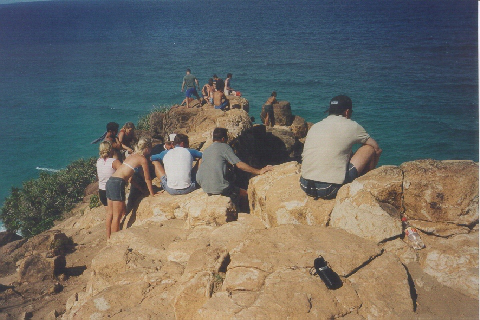

is match?1

['group-of-persons' 'rock' 'sky-light' 'vegetation']
four tourists are standing on top of a couple of grey stairs in the middle of a steep wooded slope


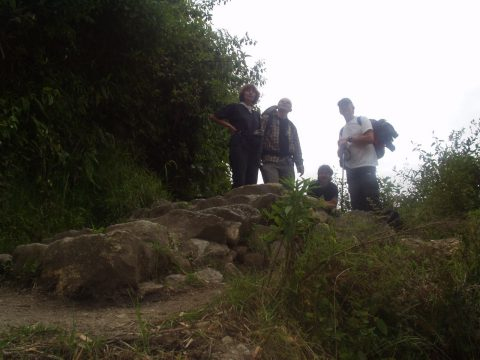

is match?1

['boat' 'group-of-persons' 'man' 'ocean' 'rock' 'sand-beach' 'sky'
 'surfboard']
four men and three surfboards at a sandy beach at the sea


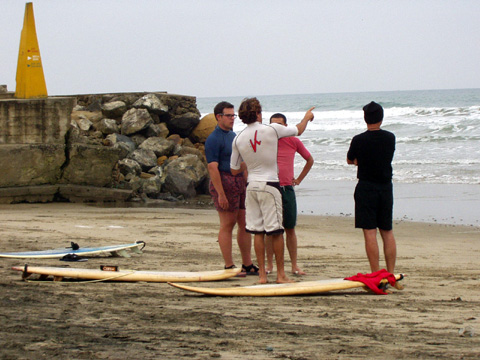

is match?1

['group-of-persons' 'lake' 'rock' 'waterfall']
Tourists with black gum boots are standing and sitting under and in front of a high waterfall over a dark grey cliff


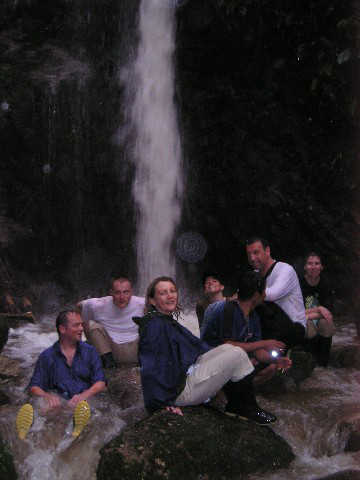

is match?1

['group-of-persons' 'mountain' 'sand-dessert' 'sky-blue']
Tourists are posing behind and next to one of several heaps of salt in a flat white salt desert with a brown mountain range in the background


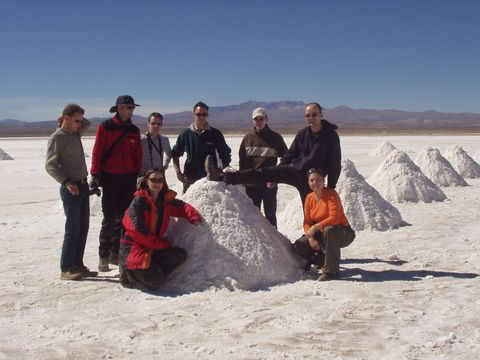

is match?1

['fabric' 'ground' 'group-of-persons' 'mountain' 'rock']
People are standing behind small walls made of grey stones with cloths on it


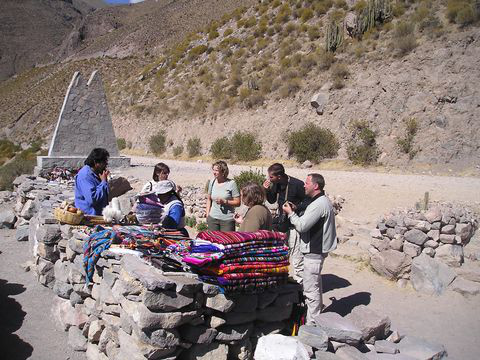

is match?1

['boat' 'cloud' 'man' 'mountain' 'ocean' 'rock']
Tourists in two small rowing boats on the grey rocky shore of a dark blue lake


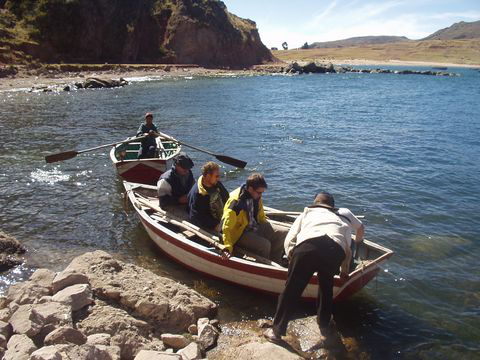

is match?0

['group-of-persons' 'mountain' 'rock' 'sky-light']
nine people are standing on grey rocks in the foreground


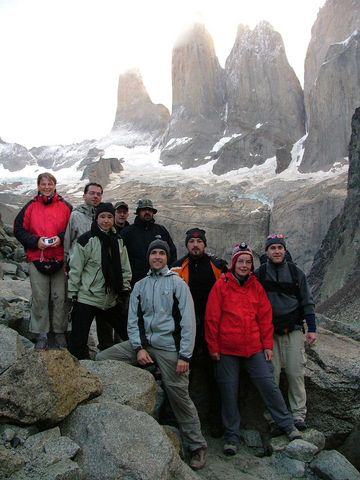

is match?1

['construction-other' 'fabric' 'fence' 'group-of-persons' 'wall']
a group of eight people with a lot of luggage is standing in a hall with light brown walls


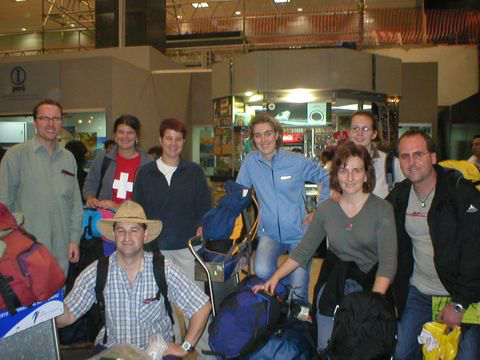

is match?1

['couple-of-persons' 'floor' 'group-of-persons' 'man' 'person' 'roof'
 'swimming-pool' 'wall']
Tourists in a blue pool


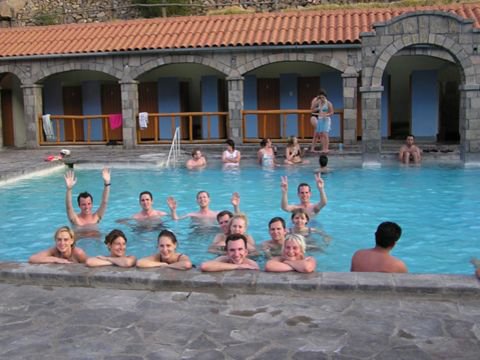

is match?1



In [221]:
display_top10(top10,keys,labels,1001)

retrivel t
20730
many backpacks are lying on a bench in the foreground
pricision 0.2
true label,['curtain' 'group-of-persons' 'wooden-furniture']

['grass' 'group-of-persons' 'man' 'person']
elderly people are walking on a lawn


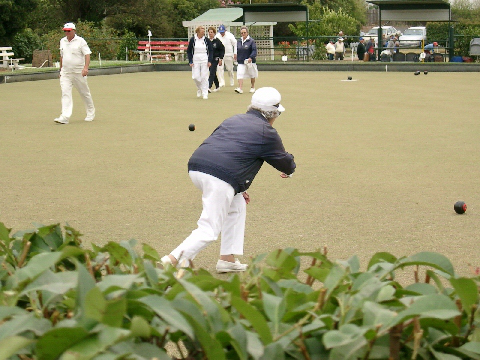

is match?1

['car' 'couple-of-persons' 'road' 'vegetation']
four tourists are sitting at the back of a pickup truck on a grey gravel road in the middle of the jungle


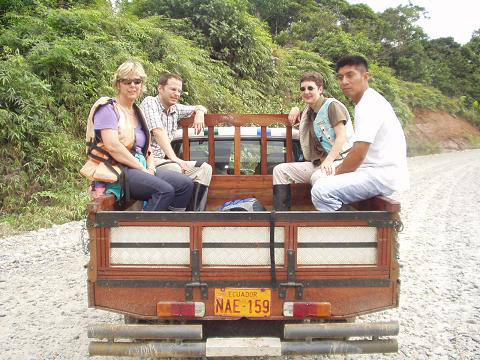

is match?0

['cloud' 'lake' 'man' 'mountain' 'public-sign' 'rock' 'vegetation']
a person is posing with a red sign in front of a mountain lake


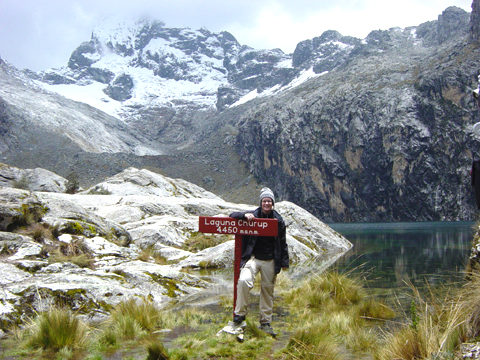

is match?0

['man' 'vegetation' 'woman']
four men and a woman in black gum boots are standing on a close path in the middle of a forest with brown trunks and many green bushes leaves and ferns


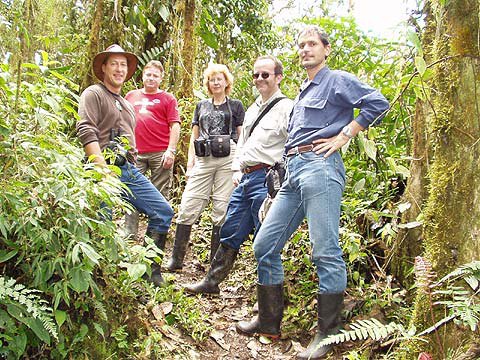

is match?0

['bush' 'hut' 'plant' 'trees' 'vegetation']
the cable of a cable car leading to a small settlement mit wooden huts and thatched roofs


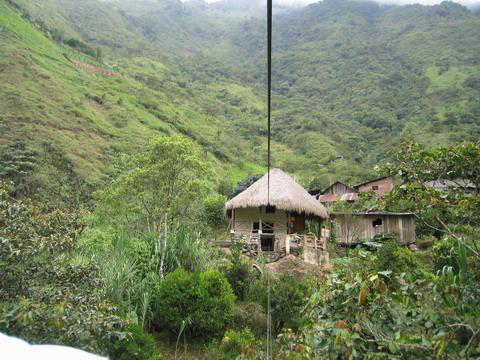

is match?0

['church' 'couple-of-persons' 'grass' 'group-of-persons' 'mountain'
 'sidewalk' 'sky-light' 'tree' 'trees']
a green square with many lawns trees and palms road lamps and people on park benches with a brown cathedral behind it


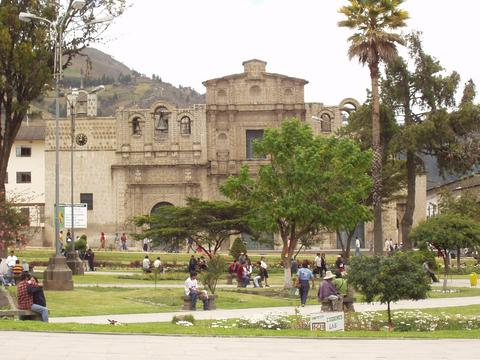

is match?1

['grass' 'highway' 'man' 'sky' 'sky-blue']
a cyclist with a red blue and white jersey black cycling shorts and a blue helmet is riding on a black and red racing bike on a grey road in a flat landscape with a green and brown meadow a fence on the right and several salient brown cliffs


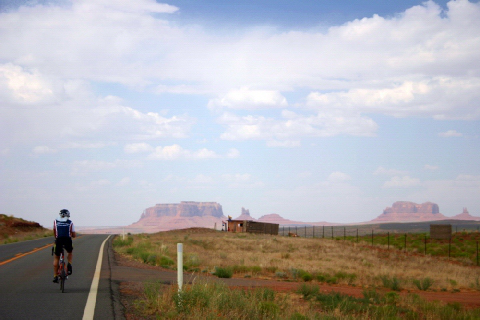

is match?0

['hill' 'plant' 'sky-blue' 'sky-light' 'vegetation']
a landscape with many dark green wooded hills


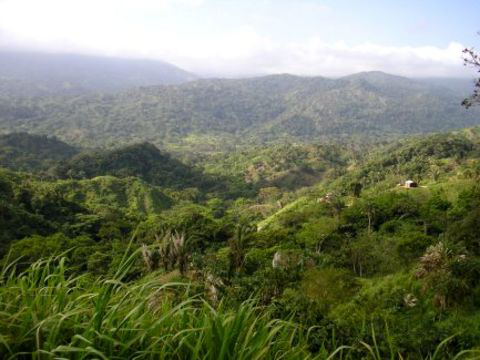

is match?0

['ground' 'leaf' 'rock' 'trunk' 'vegetation' 'water' 'waterfall']
a waterfall over a black cliff in the middle of the rain forest


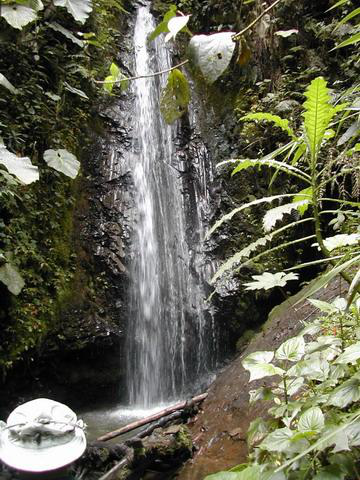

is match?0

['plant' 'river' 'rock' 'sky-light' 'vegetation' 'waterfall']
a waterfall over grey rocks in the foreground


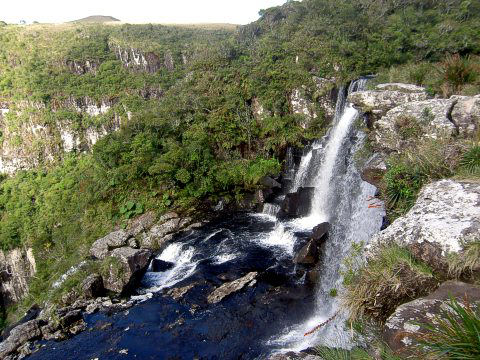

is match?0



In [222]:
display_top10(top10_base,keys,labels,1001)